<a href="https://colab.research.google.com/github/uadR1/nlphatespeech/blob/main/roberta_alldata_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Libraries
!pip install transformers
from transformers import RobertaTokenizerFast, TFRobertaForSequenceClassification, TFTrainer, TFTrainingArguments, DataCollatorWithPadding
import tensorflow as tf
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, matthews_corrcoef
from matplotlib import pyplot as plt


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.4 MB/s 
     |████████████████████████████████| 182 kB 81.2 MB/s 
     |████████████████████████████████| 7.6 MB 85.7 MB/s 


# GPU Infos

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 14 11:05:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    60W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Preprocessing of Dataset 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Read Data 
df = pd.read_csv('/content/drive/MyDrive/df_all.csv')
df.drop(columns=df.columns[0], axis=1, inplace=True)
df.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,explicit_hate
1,"rt estonian pm : "" i don't want blacks in es...",explicit_hate
2,are a bunch of religious bigots . i hope you e...,explicit_hate
3,hamas is the only one who lies and all those l...,explicit_hate
4,one of the questions never asked : if africans...,explicit_hate


In [6]:
# Check shape of dataframe 
df.shape

(64875, 2)

In [7]:
# Check if there is missing data 
df.isna().sum()

text     89
class     0
dtype: int64

In [8]:
# drop NA 
df = df.dropna()

In [9]:
# Check distribution of classes
df['class'].value_counts()

not_hate         35977
offensive        19190
implicit_hate     7100
explicit_hate     2519
Name: class, dtype: int64

In [10]:
# Combine classes for binary classification 

# Copy Dataframe first
df_binary_all = df.copy()

# Replace classes 
df_binary_all['class'] = np.where((df_binary_all['class'] == 'not_hate'), 0, df_binary_all['class'])
df_binary_all['class'] = np.where((df_binary_all['class'] == 'offensive'), 1, df_binary_all['class'])
df_binary_all['class'] = np.where((df_binary_all['class'] == 'implicit_hate'), 1, df_binary_all['class'])
df_binary_all['class'] = np.where((df_binary_all['class'] == 'explicit_hate'), 1, df_binary_all['class'])

# show head 
df_binary_all.head()

,text,class
0,rt crooked hillary you didn't lose because yo...,1
1,"rt estonian pm : "" i don't want blacks in es...",1
2,are a bunch of religious bigots . i hope you e...,1
3,hamas is the only one who lies and all those l...,1
4,one of the questions never asked : if africans...,1


In [11]:
# Show Distribution
df_binary_all['class'].value_counts()

0    35977
1    28809
Name: class, dtype: int64

In [12]:
# Get max number of words 
num_words = df_binary_all['text'].apply(lambda x:len(str(x).split()))
print('The comment with the most words consist of', num_words.max(),'words')

The comment with the most words consist of 268 words


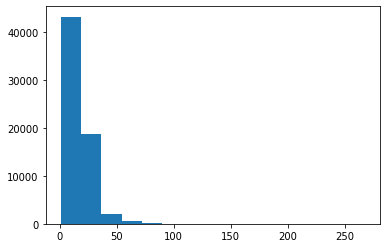

In [13]:
# Visualize 
plt.hist(num_words, bins=15)
plt.show()

No need to change hyperparameters since max word is smaller than default input allows. 

# Train-Test Split

In [14]:
# Create X  
X=list(df_binary_all['text']) 

# Create y 
y=list(df_binary_all['class']) 

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 123) 

In [15]:
# Count of Hate & Not-Hate in Train Data 
labels, count = np.unique(y_train, return_counts=True)
print('Count of Not-hate Entries:' , count[0])
print('Count of Hate Entries:' , count[1])

Count of Not-hate Entries: 28790
Count of Hate Entries: 23038


In [16]:
# All Rows Train data 
len(y_train)

51828

In [17]:
# Count of Hate & Not-Hate in Test Data 
labels, count = np.unique(y_test, return_counts=True)
print('Count of Not-hate Entries:' , count[0])
print('Count of Hate Entries:' , count[1])

Count of Not-hate Entries: 7187
Count of Hate Entries: 5771


In [18]:
# All Rows Test data 
len(y_test)

12958

# Preprocessing for Model

In [19]:
# Set up an Object for RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

# Tokenize X Train & Test Set 
train_input = tokenizer(X_train, truncation=True, padding=True, return_tensors='tf')
test_input = tokenizer(X_test, truncation=True, padding=True, return_tensors='tf')


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [20]:
# Set up a Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_input),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_input),
    y_test
))

In [22]:
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps = 500,
    weight_decay=0.01,
    logging_steps=10,
    eval_steps = 10
)

In [23]:
with training_args.strategy.scope():
    model = TFRobertaForSequenceClassification.from_pretrained("roberta-base")

trainer = TFTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=test_dataset,
)

trainer.train()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.8/dist-packages/transformers/trainer_tf.py:115: FutureWarning: The class `TFTrainer` is deprecated and will be removed in version 5 of Transformers. We recommend using native Keras instead, by calling methods like `fit()` and `predict()` directly on the model object. Detailed examples of the Keras style can be found in our examples at https://github.com/huggingface/transformers/tree/main/examples/tensorflow
  warnings.warn(


In [24]:
output = trainer.predict(test_dataset)[0]
output = np.argmax(output, axis = - 1)

In [25]:
cm=confusion_matrix(y_test,output)
cm

array([[6664,  523],
       [ 670, 5101]])

In [26]:
print(classification_report(y_test, output))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      7187
           1       0.91      0.88      0.90      5771

    accuracy                           0.91     12958
   macro avg       0.91      0.91      0.91     12958
weighted avg       0.91      0.91      0.91     12958



In [27]:
trainer.save_model('senti_model')

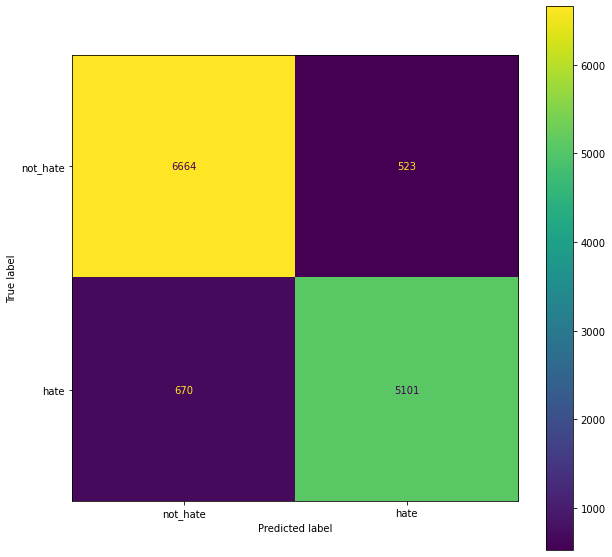

In [50]:
from sklearn import metrics

plt.rcParams['figure.figsize'] = (10, 10)
confusion_matrix = metrics.confusion_matrix(y_test, output)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["not_hate", "hate"])
cm_display.plot()

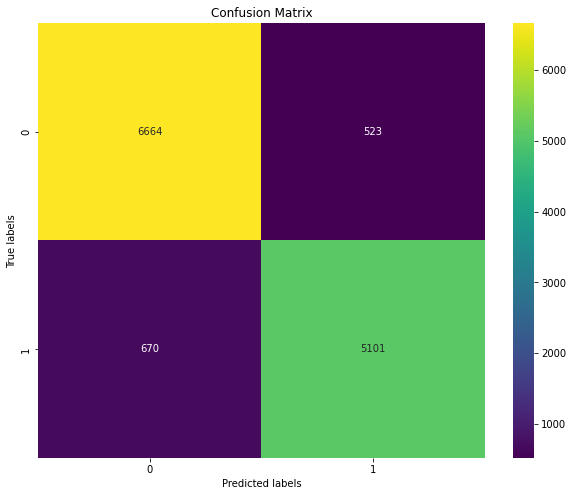

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt     

plt.rcParams['figure.figsize'] = (10, 8)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='viridis')  #annot=True to annotate cells, ftm='g' to disable scientific notation
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

In [31]:
# Loss
trainer.evaluate(test_dataset)

{'eval_loss': 0.23747620759186922}

In [35]:
# Precision Score 
accuracy = metrics.accuracy_score(y_test, output)
print(accuracy)

0.9079333230436796


In [32]:
# Precision Score 
precision = metrics.precision_score(y_test, output)
print(precision)

0.9070056899004267


In [33]:
# Recall
recall = metrics.recall_score(y_test, output)
print(recall)

0.8839022699705423


In [34]:
# F1 Score 
f1 = metrics.f1_score(y_test, output)
print(f1)

0.8953049583150504


In [54]:
X_train[21:30]

["Tommy Robinson just announced that on the 6th of May he will lead a march for everyone who believes in FREE SPEECH through the streets of London - all the way from Speaker's Corner to Twitter Headquarters. Please SHARE this message and join the battle for liberty!",
 'Looking to open a bitcoin wallet ... anyone experienced with using Electrum?    https://electrum.org/#home',
 'RT @RakwonOGOD: Bitches tweeting "last night &gt;&gt;" like they did something special except be hoes',
 'When i bitch fuck my hologram doe',
 'welcome from the state of Washington, USA',
 'RT @judiebaby_: @Vnxthny ATTENTION !!! Keshonna Alexander had the best pussy in the world. Taste good asf&#128523;&#128523;&#128525;&#128536;&#128079;&#128588;&#128514;&#128514;&#128514;&#128553;&#128540;&#128523;&#128523;&#128525;&#128525;',
 'Nip it, nip it, in the bud!',
 'How do you bloke someone on insta?? Dumb bitch scares me',
 '@austin_farrar your a fucking queer faggot bitch']

In [55]:
y_train[21:30]

[0, 0, 1, 1, 0, 1, 0, 1, 1]

In [56]:
output[21:30]

array([0, 1, 1, 1, 1, 0, 0, 0, 1])